# Installing Required Libraries

In [3]:
! pip install pytube opencv-python tensorflow

In [4]:
pip install pytube

In [5]:
pip install opencv-python

In [6]:
pip install tensorflow

# Importing Required Libraries

In [7]:
import cv2
import os
import numpy as np
from pytube import YouTube
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


# Function to download a YouTube video

In [8]:
def download_youtube_video(url, output_path):
    yt = YouTube(url)
    ys = yt.streams.get_highest_resolution()
    ys.download(output_path)
    return ys.default_filename

# Function to extract frames from a video and save as images

In [9]:
def extract_frames(video_path, output_path):
    cap = cv2.VideoCapture(video_path)
    frame_count = 0

    # Create output directory
    os.makedirs(output_path, exist_ok=True)

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_count += 1

        # Resize the frame to (128, 128) for better display
        frame = cv2.resize(frame, (128, 128))

        frame_filename = f"{output_path}/frame_{frame_count}.jpg"
        cv2.imwrite(frame_filename, frame)

    cap.release()

# Load frames and create sequences for training

In [10]:
def load_frames(input_path):
    frames = []
    for filename in sorted(os.listdir(input_path)):
        if filename.endswith(".jpg"):
            frame = cv2.imread(os.path.join(input_path, filename))
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert to RGB
            frames.append(frame)
    return np.array(frames)


# Function to build a simple convolutional autoencoder model

In this function, a convolutional autoencoder is defined using the Keras Sequential API. The autoencoder consists of convolutional layers for encoding (Conv2D) and decoding (UpSampling2D), with max-pooling layers (MaxPooling2D) to downsample the input and upsampling layers to reconstruct it. The final layer uses the sigmoid activation function to produce pixel values between 0 and 1. The model is compiled with the Mean Squared Error (MSE) loss function and the Adam optimizer.



Epoch 1/100
5/5 [==============================] - 22s 4s/step - loss: 0.0765
Epoch 2/100
5/5 [==============================] - 22s 4s/step - loss: 0.0503
Epoch 3/100
5/5 [==============================] - 15s 3s/step - loss: 0.0335
Epoch 4/100
5/5 [==============================] - 15s 3s/step - loss: 0.0244
Epoch 5/100
5/5 [==============================] - 15s 3s/step - loss: 0.0199
Epoch 6/100
5/5 [==============================] - 15s 3s/step - loss: 0.0193
Epoch 7/100
5/5 [==============================] - 15s 3s/step - loss: 0.0185
Epoch 8/100
5/5 [==============================] - 16s 3s/step - loss: 0.0163
Epoch 9/100
5/5 [==============================] - 15s 3s/step - loss: 0.0153
Epoch 10/100
5/5 [==============================] - 17s 3s/step - loss: 0.0145
Epoch 11/100
5/5 [==============================] - 18s 4s/step - loss: 0.0135
Epoch 12/100
5/5 [==============================] - 15s 3s/step - loss: 0.0131
Epoch 13/100
5/5 [==============================] - 15s 3s/st

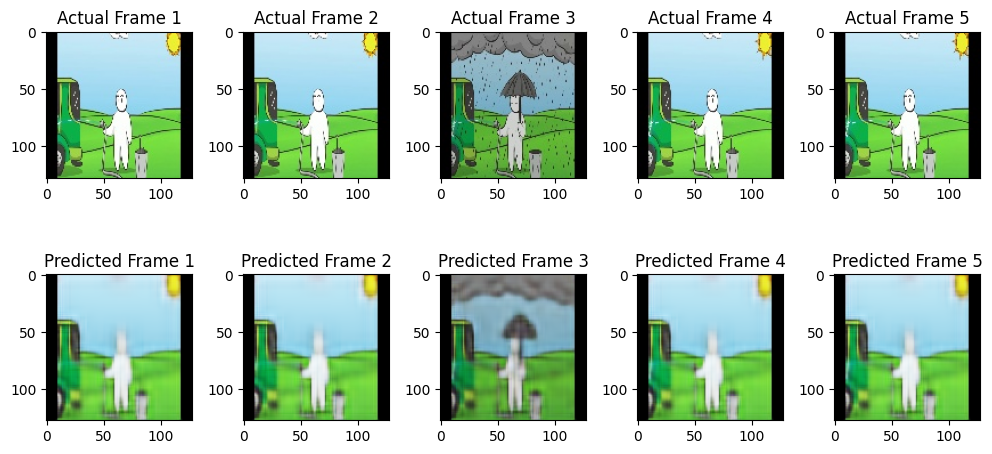

In [12]:

def build_autoencoder(input_shape):
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2), padding='same'),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2), padding='same'),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2), padding='same'),
        layers.UpSampling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.UpSampling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.UpSampling2D((2, 2)),
        layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')
    ])

    model.compile(optimizer='adam', loss='mse')
    return model

# Download YouTube video
# youtube_url = 'https://www.youtube.com/watch?v=BB49x_uMlGA'
youtube_url = 'https://www.youtube.com/watch?v=geNCpS885tg'
output_directory = '/content'
video_filename = download_youtube_video(youtube_url, '/content')
extract_frames(video_filename, output_directory)

# Load frames
frames = load_frames(output_directory)

# Normalize pixel values to be between 0 and 1
frames = frames / 255.0

# Build and train the autoencoder model
input_shape = frames[0].shape
autoencoder = build_autoencoder(input_shape)
autoencoder.fit(frames, frames, epochs=100, batch_size=20)

# Save the trained model
autoencoder.save('/content/autoencoder_model.h5')

# Choose 5 frames for prediction
sample_frames = frames[:5]

# Predict the next frames
predicted_frames = autoencoder.predict(sample_frames)

# Display actual and predicted frames with improved spacing
fig = plt.figure(figsize=(10, 5))
gs = gridspec.GridSpec(2, 5, width_ratios=[1, 1, 1, 1, 1], height_ratios=[1, 1])

for i in range(5):
    plt.subplot(gs[0, i])
    plt.imshow(sample_frames[i])
    plt.title(f"Actual Frame {i + 1}")

    plt.subplot(gs[1, i])
    plt.imshow(predicted_frames[i])
    plt.title(f"Predicted Frame {i + 1}")

# Adjust layout to add spacing
plt.tight_layout()
plt.show()
